<a href="https://colab.research.google.com/github/dawidstajszczyk/thesis_APO/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

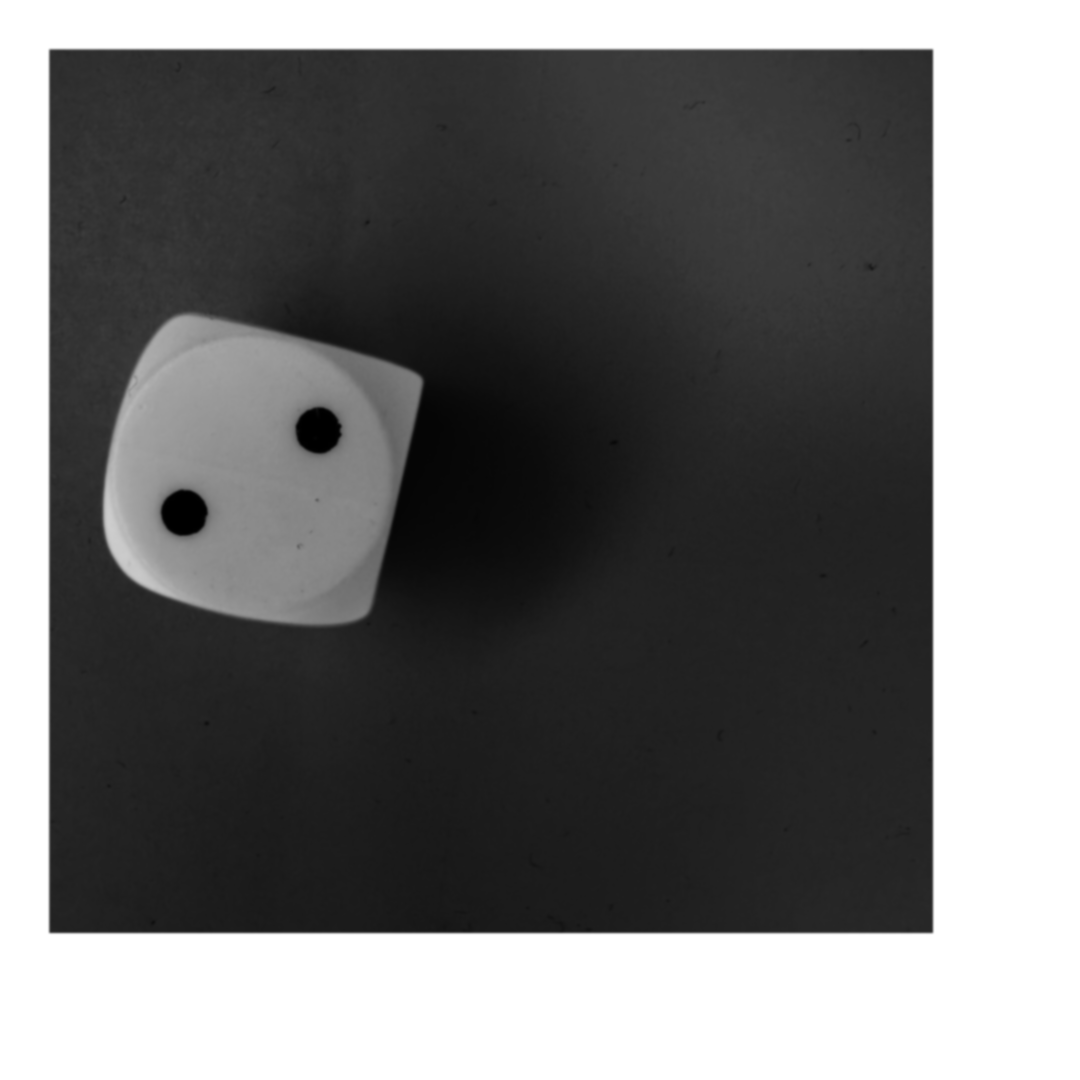

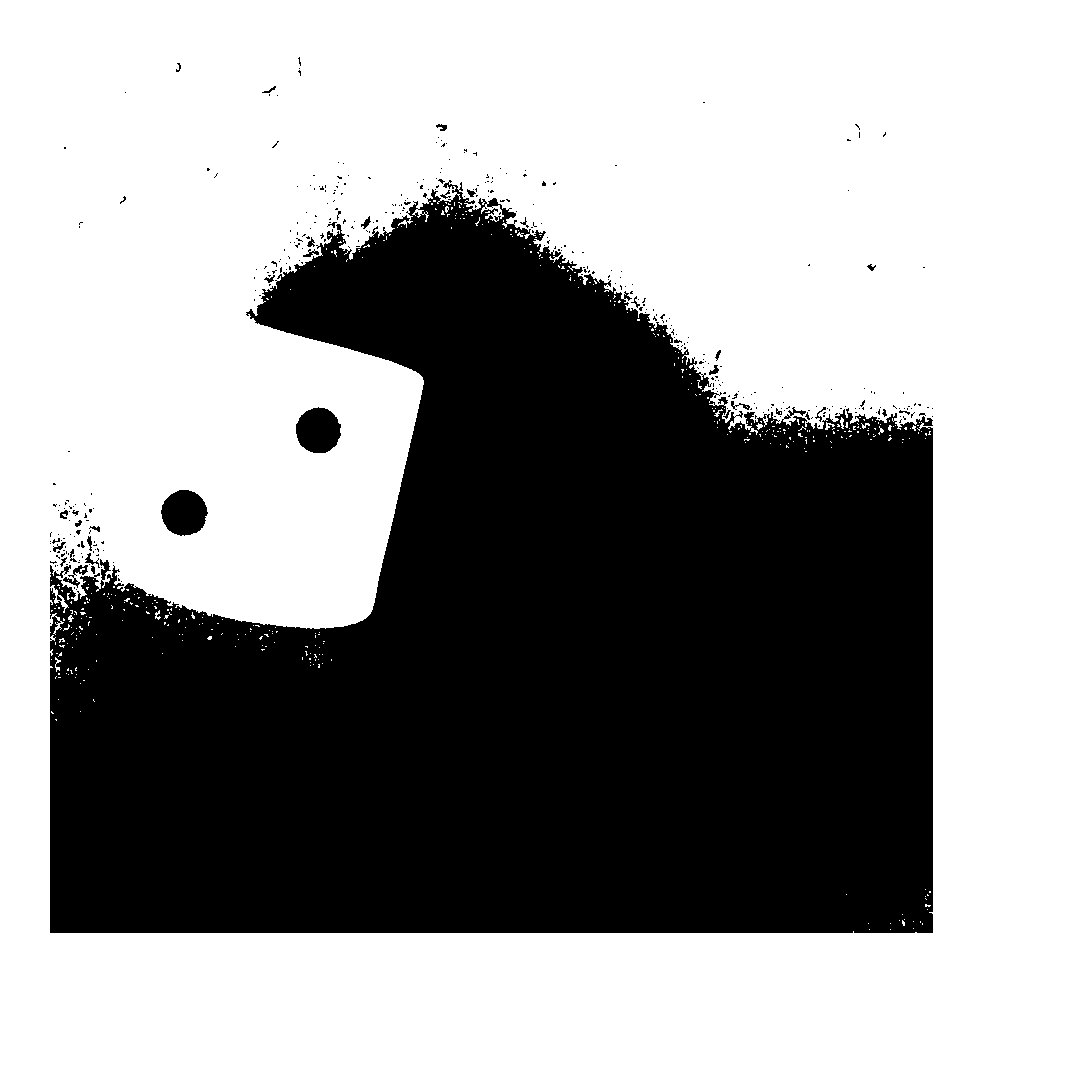

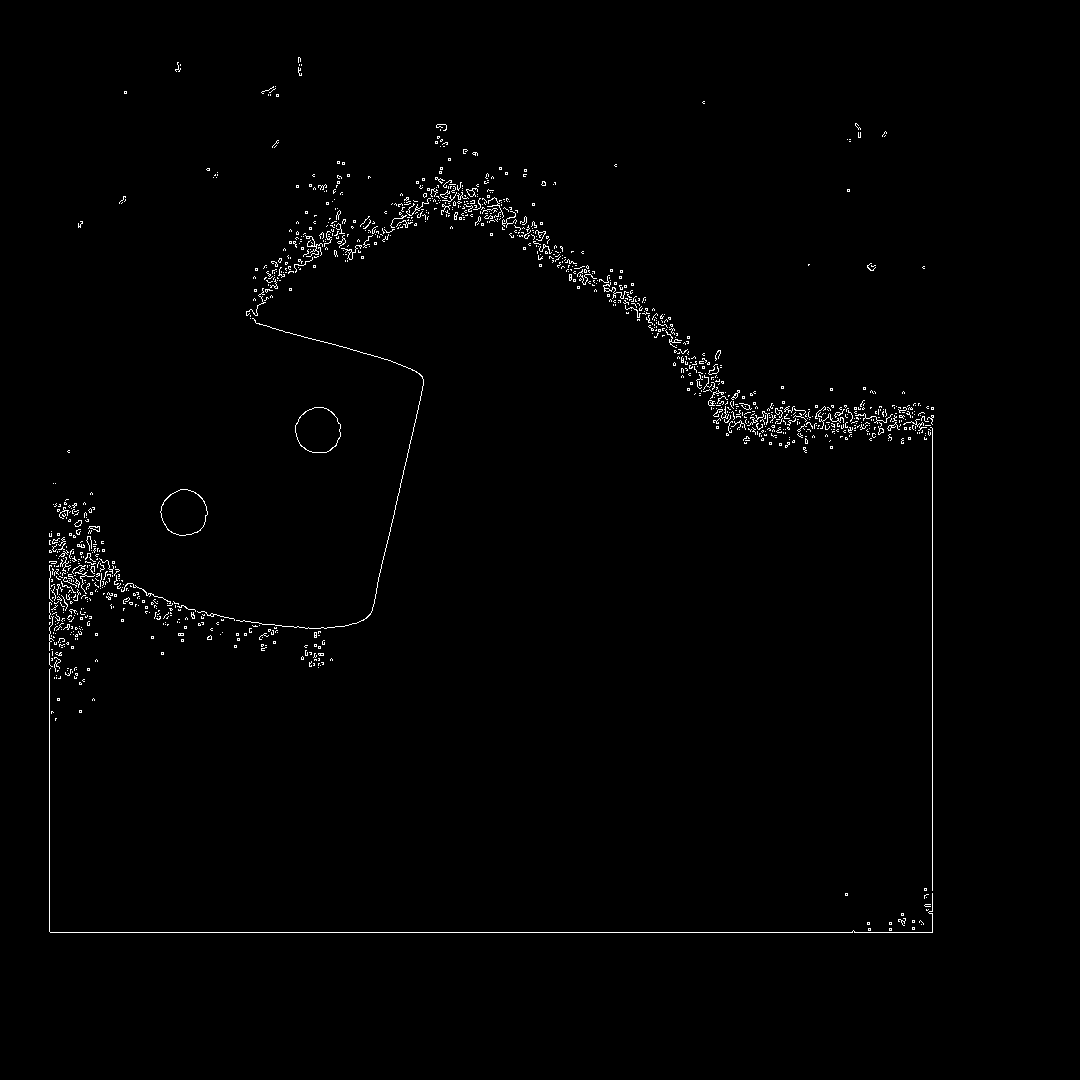

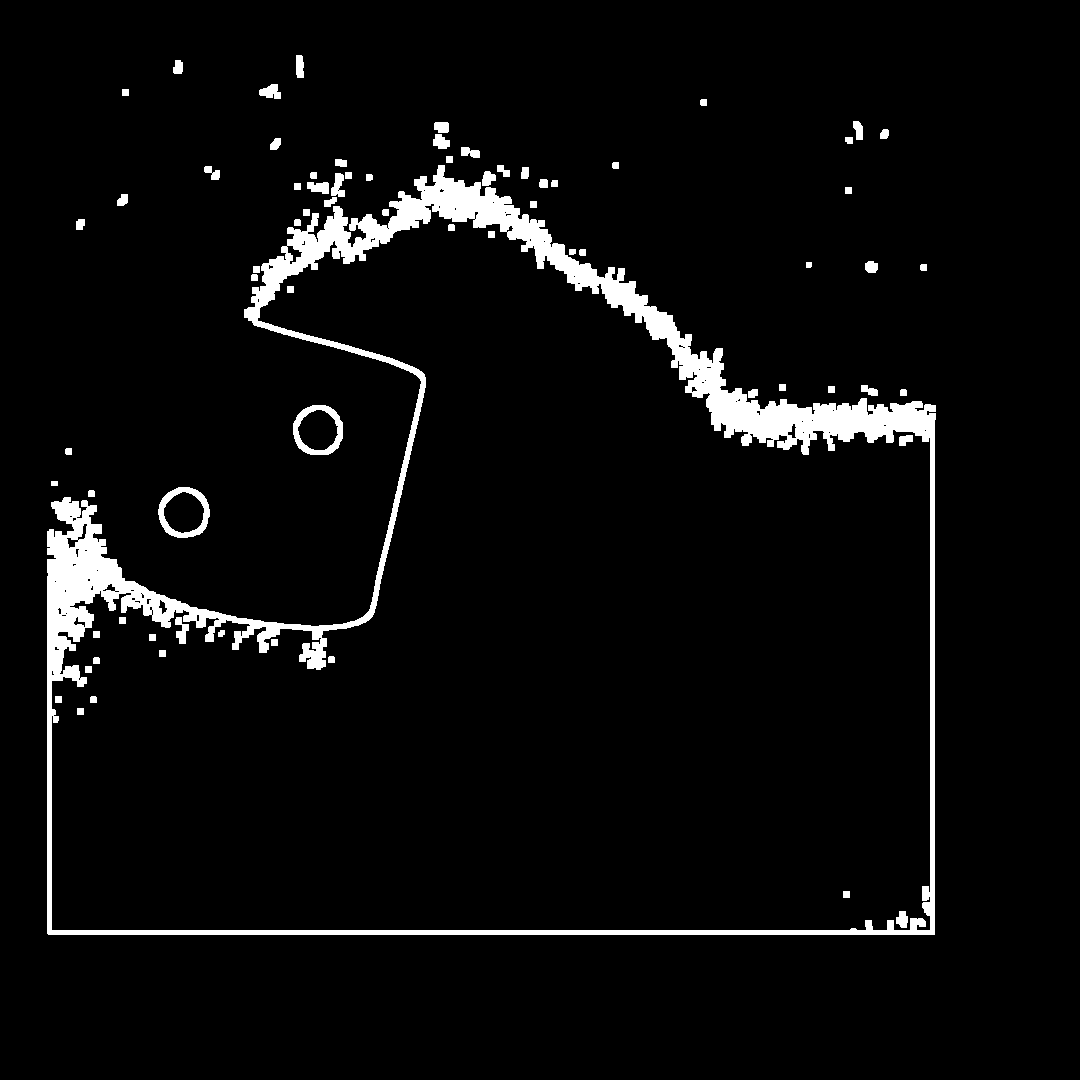

area:  35.0
area:  2034.0
circ:  0.8806171822495812
area:  24.0
area:  35.0
area:  1984.0
circ:  0.8970666384742177
area:  35.0
area:  60.5
area:  36.0
area:  95.0
area:  36.0
area:  35.0
area:  36.0
area:  35.0
area:  24.5
area:  112.0
circ:  0.8245927868464537
area:  35.0
area:  28.5
area:  35.0
area:  69.0
area:  35.0
area:  36.0
area:  36.0
area:  66.0
area:  86.0
area:  36.0
area:  36.0
area:  175.0
circ:  0.497504361478726
area:  34.5
area:  60.5
area:  34.0
area:  186.0
circ:  0.374793754939033
area:  36.0
area:  35.0
area:  129.0
circ:  0.6665983746846322
area:  71.0
area:  101.0
circ:  0.3607622473504885
area:  73.0
area:  470430.5
circ:  0.2546513023527632
area:  35.0
area:  68.0
area:  36.0
area:  120.5
circ:  0.43904359391361547
area:  83.5
area:  38.5
area:  156.5
circ:  0.6037987519620321
area:  62.0
area:  127.0
circ:  0.7655994558624012
area:  120.5
circ:  0.6081414652799297
area:  35.0
area:  36.0
area:  191.0
circ:  0.45076256720883595
area:  98.0
area:  141.5
circ:  

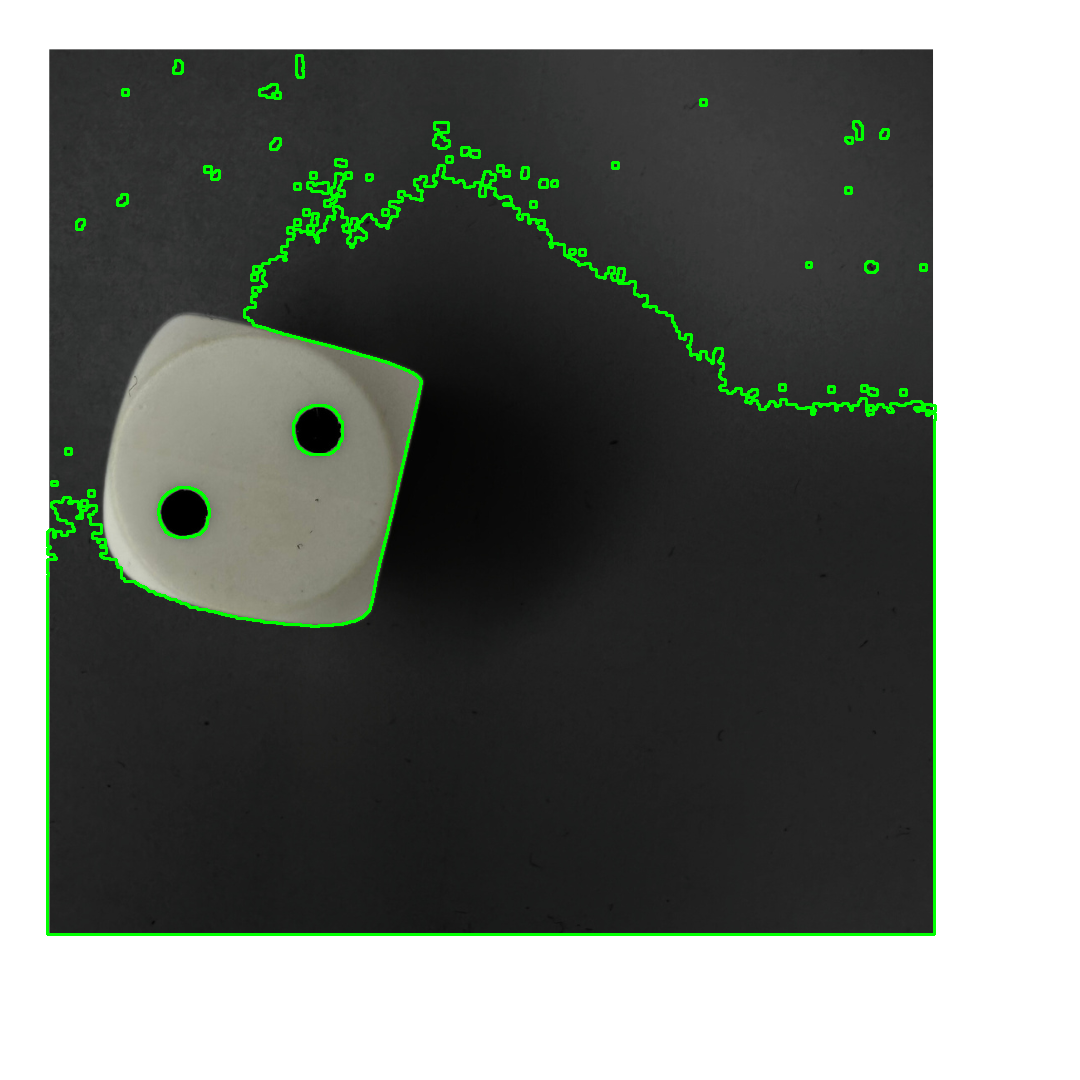

Liczba czarnych kropek: 3


In [8]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def count_black_dots(image_path):
    # Wczytanie obrazu
    image = cv2.imread(image_path)

    # Przekształcenie obrazu na odcienie szarości
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Rozmycie Gaussowskie w celu wygładzenia krawędzi
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    cv2_imshow(blurred)

    # Binaryzacja obrazu (czarne kropki będą miały wartość 0)
    _, binary = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)
    cv2_imshow(binary)

    # Detekcja krawędzi w obrazie
    edges = cv2.Canny(binary, 50, 150)
    cv2_imshow(edges)

    # Zastosowanie dylatacji w celu połączenia ewentualnych przerw w krawędziach
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    cv2_imshow(dilated)

    # Znalezienie konturów w obrazie
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Utworzenie kopii obrazu, na którym będą rysowane kontury czarnych kropek
    dots_image = image.copy()
    cv2.drawContours(dots_image, contours, -1, (0, 255, 0), 2)

    # Zliczenie czarnych kropek na podstawie pola powierzchni i kolistości
    black_dot_count = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100:  # Minimalna wielkość obszaru, aby uznać go za czarną kropkę
            continue

        # Sprawdzenie, czy kontur jest zbliżony do kształtu okręgu
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > 0.8:  # Określ próg, powyżej którego uznajemy kształt za okrągły
            cv2.drawContours(dots_image, [contour], -1, (0, 255, 0), 2)
            black_dot_count += 1

    # Wyświetlenie obrazu z konturami czarnych kropek
    cv2_imshow(dots_image)

    return black_dot_count

# Ścieżka do zdjęcia
image_path = "/content/Untitled design (1).png"

# Zliczenie czarnych kropek
dots_count = count_black_dots(image_path)
print("Liczba czarnych kropek:", dots_count)


1. Ładowanie obrazu
2. Konwersja do skali szarości
3. Rozmycie Gaussowskie
4. Binaryzacja obrazu
5. Detekcja krawędzi
6. Dylatacja
7. Znalezenie konturów
7. Klasyfikacja konturów na podstawie obszaru i kolistości